#### Notes

This file contains the code used for the simulations for CIFAR-10 dataset.

(This file contains the code for our algorithm and for GDA, for the CIFAR dataset.  For our algorithm with acceptance rate 1/2, set the "rate" paramter to "rate = 2".  For GDA, set the "rate" parameter to rate = 1.)

For OMD, results are obtained using implementation here - https://github.com/vsyrgkanis/optimistic_GAN_training

In [21]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
from keras.datasets import cifar10
import time
from keras import backend as K
import random


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.optimizers import Adam#, SGD
import sys
sys.path.append("../")

from utils_CIFAR import *       # utils file has the filler code and helper functions

from tqdm.notebook import tqdm
from functools import partial
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
K.clear_session()

In [10]:
%%time

# load cifar10 images
(train_images, _), (test_images, _) = cifar10.load_data()
shuffle(train_images)
shuffle(test_images)

CPU times: user 218 ms, sys: 129 ms, total: 347 ms
Wall time: 346 ms


In [11]:
NOISE_SIZE = 100
IMAGE_SHAPE = (32,32,3)

In [12]:
#set filter = False to include the entire CIFAR-10 dataset
X, _, _, _ = load_data(filter=False)

In [13]:
adam_optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
take_discriminator_steps_2 = partial(take_discriminator_steps, X_train=X, k=1)
getLoss2 = partial(getLoss, X_train=X)
create_gan2 = partial(create_gan, opt=adam_optimizer)

def create_GAN_player():
    ganPlayer = Players(create_generator(IMAGE_SHAPE, opt=adam_optimizer), 
                        create_discriminator(INPUT_SHAPE=IMAGE_SHAPE, opt=adam_optimizer), 
                        create_gan2, 
                        take_generator_steps, 
                        take_discriminator_steps_2, 
                        change_network, 
                        change_network, 
                        perturb_generator)    
    return ganPlayer


In [14]:
def singleStep(player, player2, j, losses, k=1):
    rate = 1
    if j%rate != 0:

        player2.change_x(player.get_x())        
        player2.change_y(player.get_y())


    if j>0:
        loss_old = player.value(getLoss2)  
        losses.append(loss_old)

    # perform one gradient update for the generator and k gradient updates for the discriminator (we only use "k=1" discriminator gradient steps for CIFAR)
    player.update_x()
    for s in range(k):
        player.update_y()        

    #Accept/reject Step
    if j%rate != 0:
        loss_new = player.value(getLoss2)            

        if loss_new > loss_old:
            print("Reject")
            player.change_x(player2.get_x())        
            player.change_y(player2.get_y())
        else:
            print("Accept")
    

In [26]:
# Train using our algorithm
def run_mx(r):

    K.clear_session()
    print ("Running minimax algorithm")
    
    model = InceptionV3()    
    T= 50000
    adam_optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    take_discriminator_steps_2 = partial(take_discriminator_steps, X_train=X, k=1)
    getLoss2 = partial(getLoss, X_train=X)
    create_gan2 = partial(create_gan, opt=adam_optimizer)

    def create_GAN_player():
        ganPlayer = Players(create_generator(IMAGE_SHAPE, opt=adam_optimizer), 
                            create_discriminator(INPUT_SHAPE=IMAGE_SHAPE, opt=adam_optimizer), 
                            create_gan2, 
                            take_generator_steps, 
                            take_discriminator_steps_2, 
                            change_network, 
                            change_network, 
                            perturb_generator)    
        return ganPlayer

    
    player = create_GAN_player()
    player2 = create_GAN_player()

    losses=[]
    pairwise_squared_distances=[]

    FID_scores=[]

    old_loss = 100
    player.update_y()

    rate = 2
    inception_scores_mx = []

    for j in tqdm(range(T)):

        singleStep(player, player2, j, losses)

        if j%500 == 0:
            inception_scores_mx.append(get_inception_score(model, player))

    player.get_x().save_weights(os.path.join('output/mx_wts', 'epoch_{}_g.h5'.format(r)))
    player.get_y().save_weights(os.path.join('output/mx_wts', 'epoch_{}_d.h5'.format(r)))
    
    print (inception_scores_mx[-1])    
    return inception_scores_mx

# Train using GDA
def run_gda(r):

    print ("Running GDA algorithm")
    K.clear_session()
    model = InceptionV3()    
    T= 50000

    adam_optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    take_discriminator_steps_2 = partial(take_discriminator_steps, X_train=X, k=1)
    getLoss2 = partial(getLoss, X_train=X)
    create_gan2 = partial(create_gan, opt=adam_optimizer)

    def create_GAN_player():
        ganPlayer = Players(create_generator(IMAGE_SHAPE, opt=adam_optimizer), 
                            create_discriminator(INPUT_SHAPE=IMAGE_SHAPE, opt=adam_optimizer), 
                            create_gan2, 
                            take_generator_steps, 
                            take_discriminator_steps_2, 
                            change_network, 
                            change_network, 
                            perturb_generator)    
        return ganPlayer

    player = create_GAN_player()
    inception_scores = []
    player.update_y()

    for j in tqdm(range(T)):

        player.update_x()
        k = 1
        for s in range(k):
            player.update_y()        


        if j%500 == 0:
            inception_scores.append(get_inception_score(model, player))

    player.get_x().save_weights(os.path.join('output/gda_wts', 'rep_{}_g.h5'.format(r)))
    player.get_y().save_weights(os.path.join('output/gda_wts', 'rep_{}_d.h5'.format(r)))
    
    print (inception_scores[-1])
    return inception_scores


In [ ]:
# Expts in the paper used 20 repetitions
reps = 2
scores = {"gda": [], "mx": []}

for r in tqdm(range(reps)):    
    scores["mx"].append(run_mx(r))    
    scores["gda"].append(run_gda(r))  
    

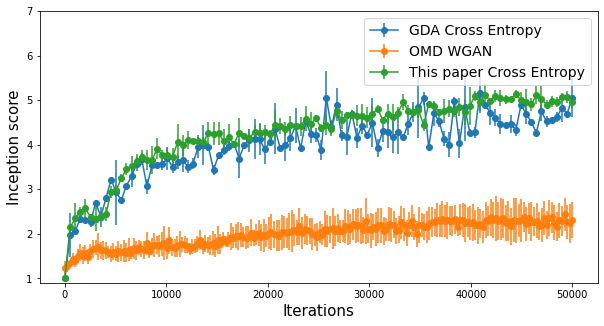

In [44]:
plt.figure(figsize=(10,5))

plt.errorbar(np.linspace(0, 50000, 100), np.mean(scores["gda"], axis=0), np.std(scores["gda"], axis=0), label="GDA Cross Entropy", fmt="-o")
plt.errorbar(np.linspace(0, 50000, 100), np.mean(scores_mx, axis=0), np.std(scores_mx, axis=0), label="This paper Cross Entropy", fmt="-o")

# Get OMD WGAN scores using code from https://github.com/vsyrgkanis/optimistic_GAN_training
# plt.errorbar(np.linspace(0, 50000, 200), np.mean(omd_wgan, axis=0), np.std(omd_wgan, axis=0), label="OMD WGAN", fmt="-o")

plt.xlabel("Iterations", fontsize=15)
plt.ylabel("Inception score", fontsize=15)
plt.ylim(0.9, 7)
plt.legend(fontsize=14)

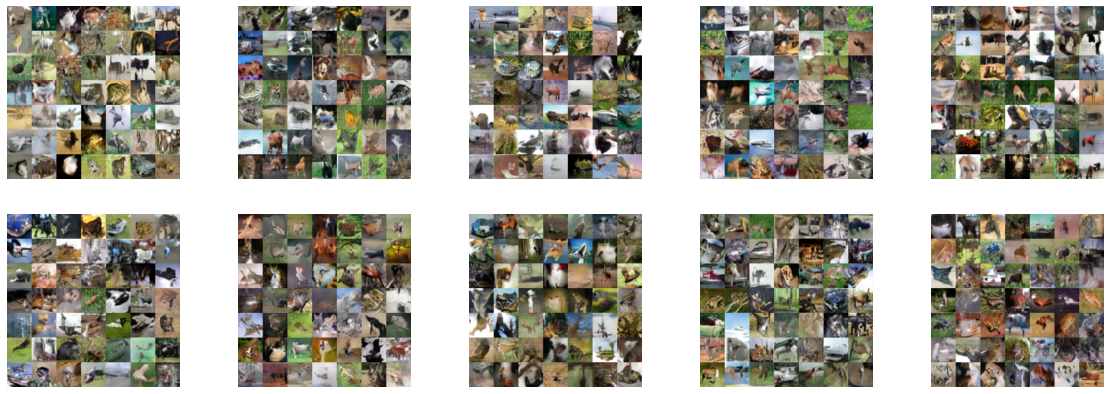

In [84]:
from PIL import Image
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 7))

m=7
n = m**2
player = create_GAN_player()

for i in range(10):
    j=i
    player.get_x().load_weights('output/mx_wts/epoch_'+str(j)+'_g.h5')

    noise= np.random.normal(loc=0, scale=1, size=[n, 100])
    generated_images = player.get_x().predict(noise)
    generated_images = generated_images.reshape(n, *IMAGE_SHAPE)
    generated_images = (generated_images + 1.0)/2.0

    scores = list()
    generated_images = generated_images.astype('float32')
    generated_images = scale_images(generated_images, (299,299,3))

    t_sample = np.concatenate(np.asarray([np.concatenate(generated_images[(i*m):(i*m+m)], axis=1) for i in range(m)]), axis=0)
    ax[int(i/5),i%5].imshow(t_sample)
    ax[int(i/5),i%5].axis('off')
plt.show()